The Dataset of the Airbus Ship Detection Challenge consists of:
<ul>
    <li>"train_v2" and "train_v2" folders with images for training and testing.</li>
    <li>the train_ship_segmentations_v2.csv file provides the ground truth (in run-length encoding format) for the training images contained in the "train_v2".</li>
    <li>the sample_submission_v2.csv file contains list of test images in "test_v2".</li>
</ul>
"train_v2" and "train_v2" are ignored in git

In [19]:
%matplotlib inline

In [48]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pandas as pd

First, load train_ship_segmentations_v2.csv into a dataframe using pandas

In [21]:
data_set = pd.read_csv('train_ship_segmentations_v2.csv')
data_set.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


The code is suitable only for square sized input images.

In [22]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3

To extract the ground truth masks for images from the dataframe, define next functions: get_mask_coords - turns dataframe string format of the encoded pixels into their position in the image array; fill_mask - merges received mask points with mask image array

In [23]:
#Extracts mask pixels from the dataset
def get_mask_coords(img_id, mask_dataframe):
    def group_mask_coords(mask_crds):
        temp_mask=[]
        for i in range(len(mask_crds)):
            if i%2 == 0:
                temp_mask.append([mask_crds[i],mask_crds[i+1]])
        return temp_mask

    subdf = mask_dataframe.loc[(mask_dataframe['ImageId'] == img_id)]
    mask_coords=""
    for row in range(len(subdf)):
        tmp = subdf.iloc[row]['EncodedPixels']
        mask_coords += (tmp if pd.notna(tmp) else "") + ' '
    mask_coords = list(map(int, mask_coords.split()))
    mask_coords = group_mask_coords(mask_coords)
    return mask_coords

#Fills mask array with boolean values based on coordinates of encoded pixels in the dataset
def fill_mask(mask_crds):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for m_crd in mask_crds:
        for i in range(m_crd[1]):
            x, y = np.divmod((m_crd[0] + i), IMG_HEIGHT)
            mask[y][x] = True
    return mask

To demonstrate the model performance it will be trained on a small set of images, as the computation capacities of the device I'm using doesn't allow me to train the model on the entire dataset which is made up of 192 556 images. For instance, a set of a 100 images will be used for training stored in the "train" folder. X_train and Y_train arrays will store given set of images and masks for them.

In [24]:
#Extracting names of the images which will be used for identification
train_ids = next(os.walk("train/"))[2]

#X_train will contain extracted images
#Y_train will contain masks (the ground-truth dataset)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

In [25]:
#Filling X_train and Y_train with images and masks
print('Loading train images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = "train/" + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    X_train[n] = img
    Y_train[n] = fill_mask(get_mask_coords(id_, data_set))

Loading train images and masks


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.22it/s]


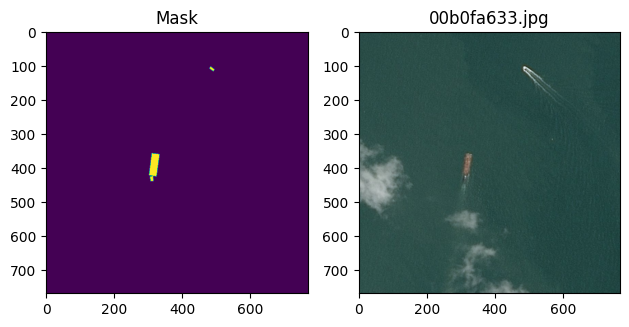

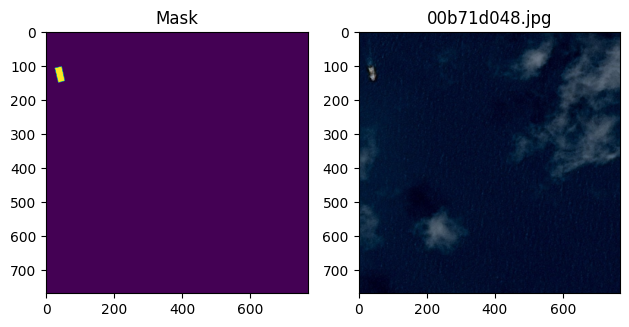

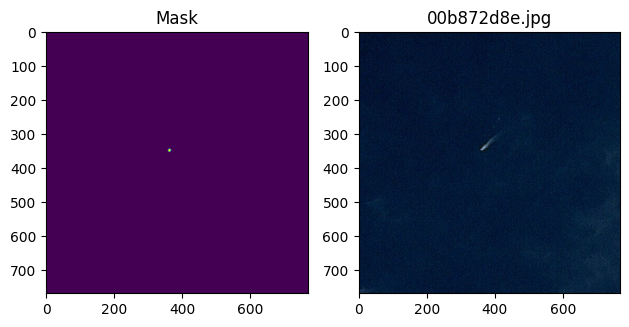

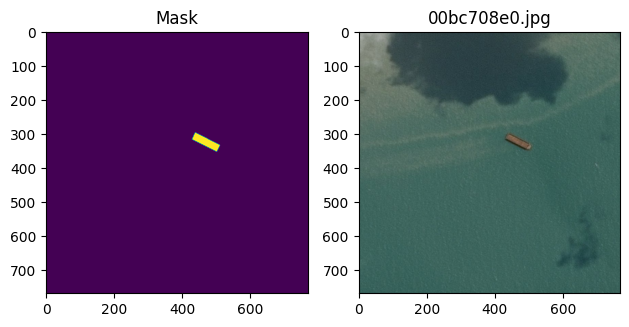

In [31]:
for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(Y_train[i])
    ax2.imshow(X_train[i])
    ax1.title.set_text('Mask')
    ax2.title.set_text(train_ids[i])
    plt.tight_layout()
    plt.show()

To train the model execute "model_training.py" which will take quite some time. By the end of the execution the trained model will be stored in 'model.h5'. Then load it for further testing.

In [32]:
model = tf.keras.models.load_model('model.h5')

For testing, switch to the 'test' folder which should contain a set of images taken from "train_v2" so that we can evaluate the dice score between the model prediction and the ground truth.

In [33]:
TEST_PATH = 'test/'

The function plots the result of model prediction on the set of images in "test".

In [34]:
#Function for testing all images in the TEST_PATH folder 
#and plots prediction for every image in a given folder one by one
def Test_all_in_folder(path, model):
    test_ids = next(os.walk(path))[2]
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    print('Testing') 

    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        img_path = path + id_
        img = imread(img_path)[:,:,:IMG_CHANNELS]
        X_test[n] = img

    preds_test = model.predict(X_test, verbose=1)

    for i in range(len(X_test)):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(np.squeeze(preds_test[i]))
        ax2.imshow(np.squeeze(X_test[i]))
        ax1.title.set_text('Prediction')
        ax2.title.set_text(test_ids[i])
        plt.tight_layout()
        plt.show()

Testing


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 96.92it/s]


1/1 [==============================] - 3s 3s/step


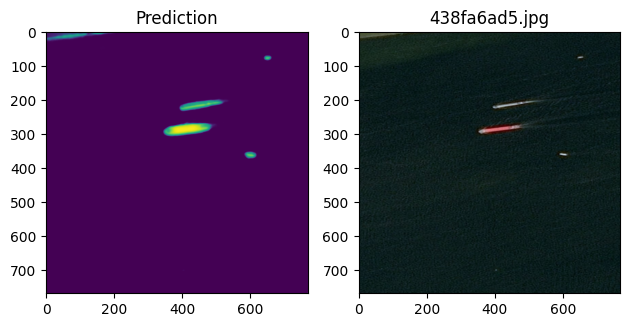

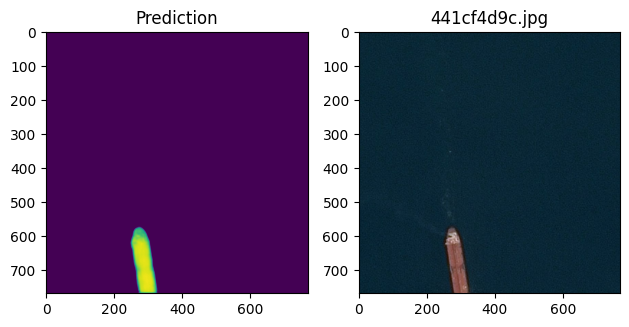

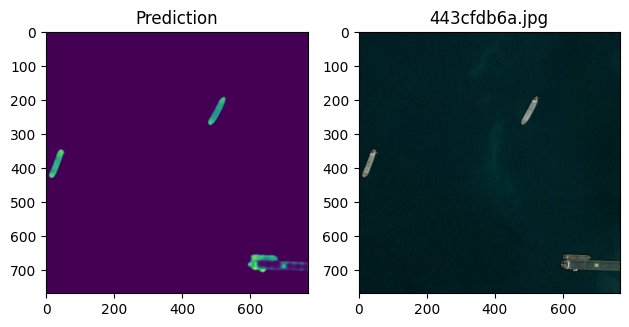

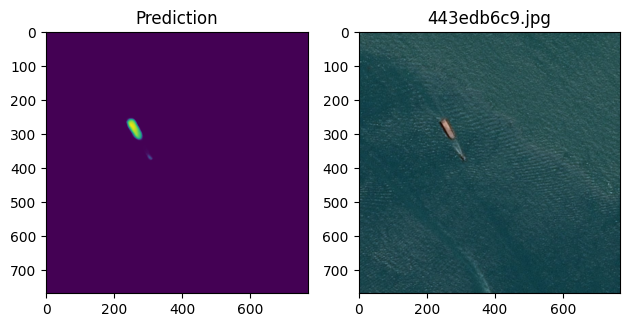

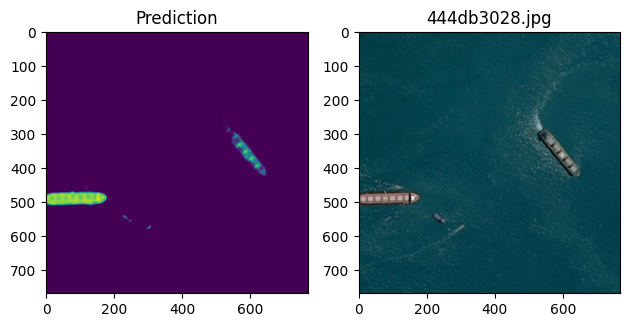

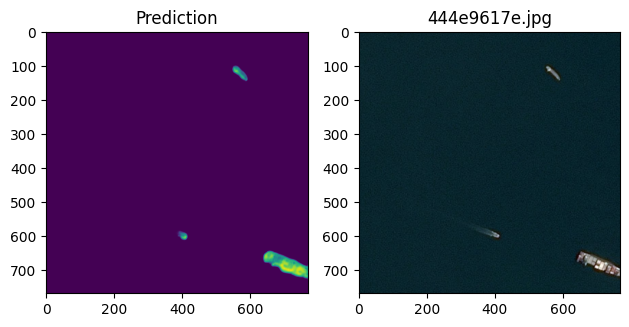

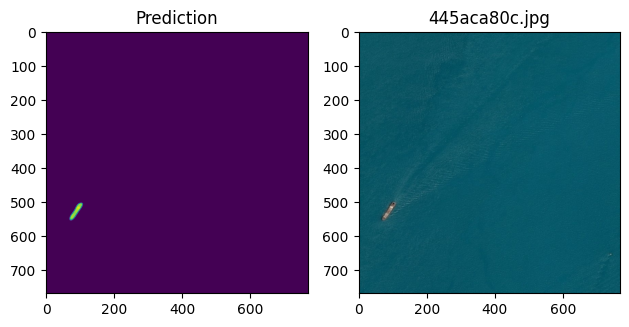

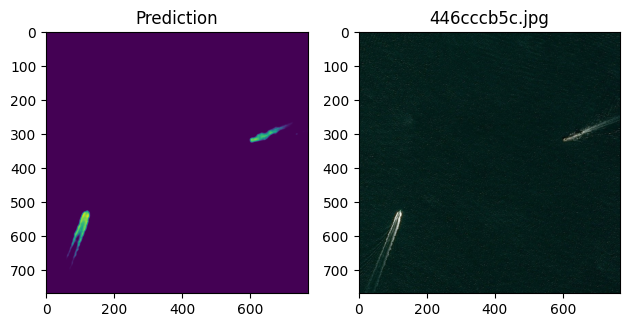

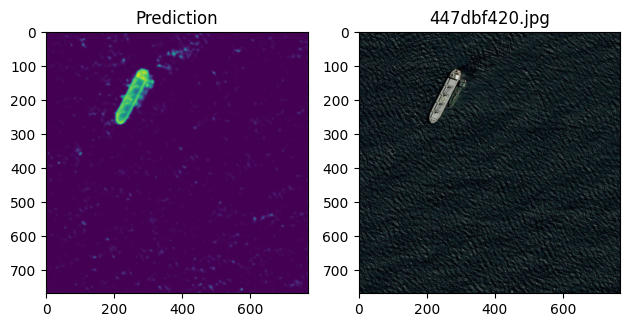

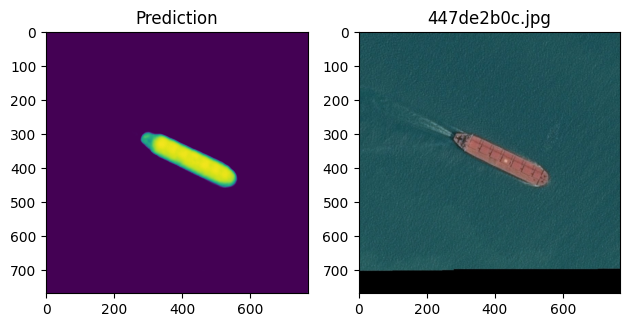

In [35]:
Test_all_in_folder(TEST_PATH, model=model)

Calculation of the dice score:

In [37]:
#Calculating the dice score
def dice_score(im1, im2):

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [41]:
#Testing images taken from the train dataset (train_v2 in the .zip file of the challenge) for calculating dice score
def Test_with_dice_score(dataset_file, img_path, model, plot):
    test_ids = next(os.walk(img_path))[2]
    data_set = pd.read_csv(dataset_file)
    data_set = data_set.loc[(data_set['EncodedPixels'].notnull())]
    mask = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i in range(len(test_ids)):
        mask[i] = fill_mask(get_mask_coords(test_ids[i], data_set))
        images[i] = imread(img_path + test_ids[i])[:,:,:IMG_CHANNELS]
    pred = model.predict(images, verbose=0)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    pred = pred.astype(np.bool_)
    for i in range(len(test_ids)):
        dice = dice_score(mask[i], pred[i])
        print(" Image name: " + test_ids[i] + "; Dice Score: " + str(dice))
        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(pred[i])
            ax2.imshow(mask[i])
            ax1.title.set_text('Prediction')
            ax2.title.set_text('Mask')
            plt.tight_layout()
            #plt.gcf().text(0.05, 0.9, "Dice Score: " + str(dice), fontsize=12)
            plt.show()

Note: for receiving the dice score, images must be taken from "train_v2" in order to get the mask for them.

 Image name: 438fa6ad5.jpg; Dice Score: 0.6560253699788583


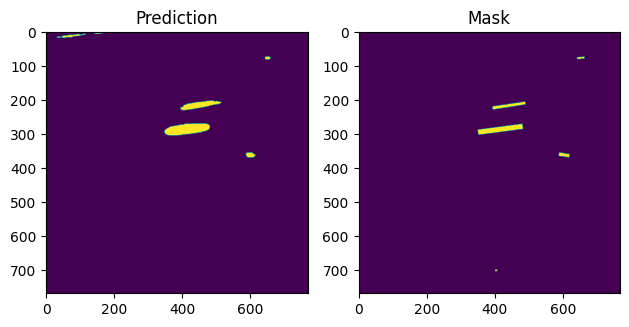

 Image name: 441cf4d9c.jpg; Dice Score: 0.9242684073684793


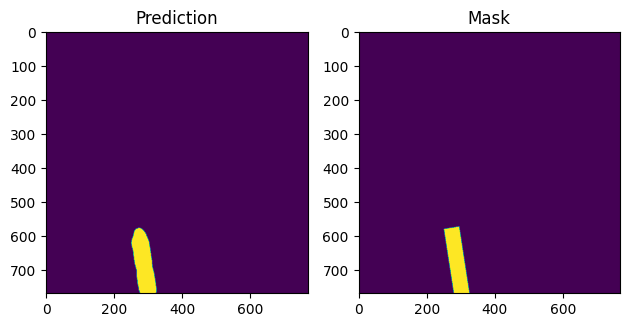

 Image name: 443cfdb6a.jpg; Dice Score: 0.47761652461030485


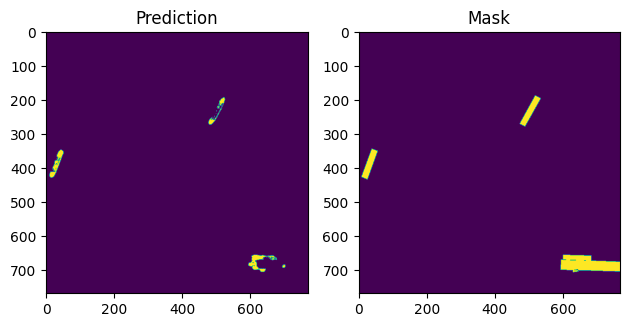

 Image name: 443edb6c9.jpg; Dice Score: 0.7436065573770492


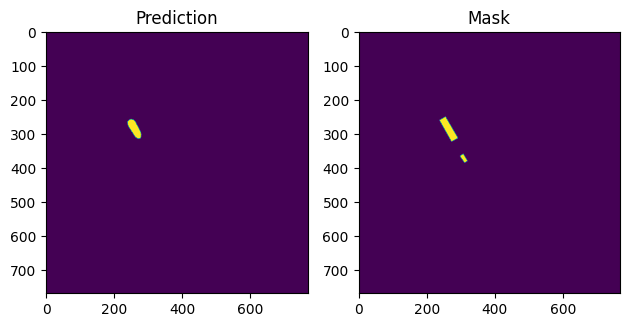

 Image name: 444db3028.jpg; Dice Score: 0.6435361216730038


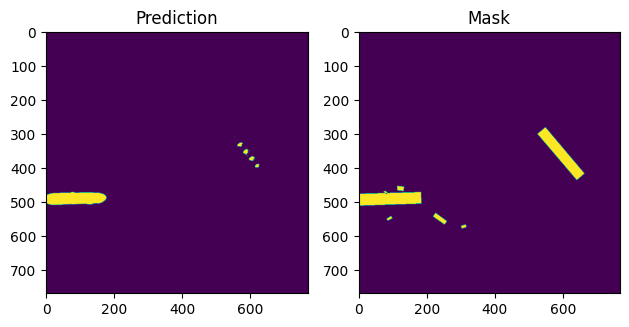

 Image name: 444e9617e.jpg; Dice Score: 0.7906850308082639


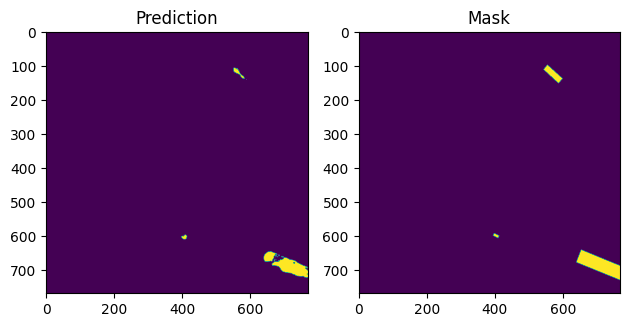

 Image name: 445aca80c.jpg; Dice Score: 0.777120315581854


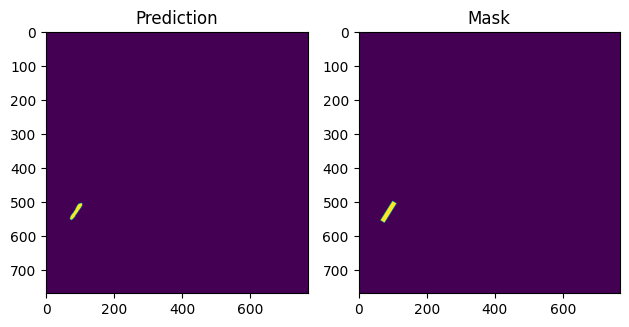

 Image name: 446cccb5c.jpg; Dice Score: 0.3914147242095546


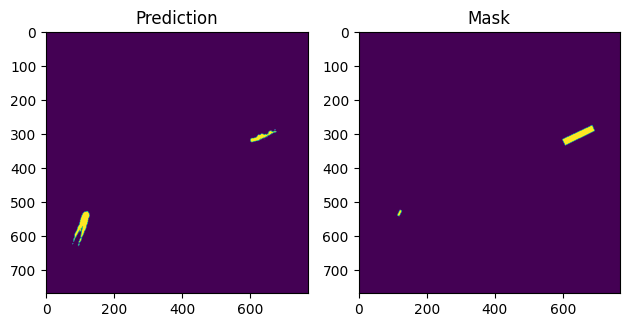

 Image name: 447dbf420.jpg; Dice Score: 0.7841347841347841


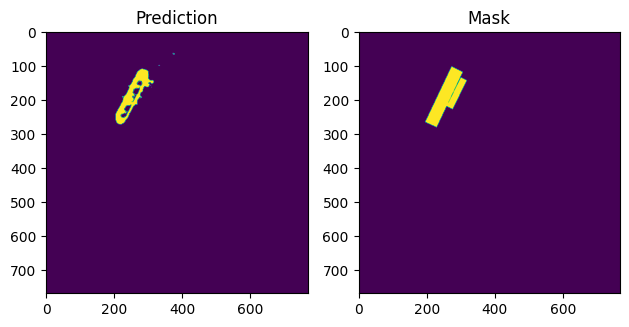

 Image name: 447de2b0c.jpg; Dice Score: 0.9272624333263804


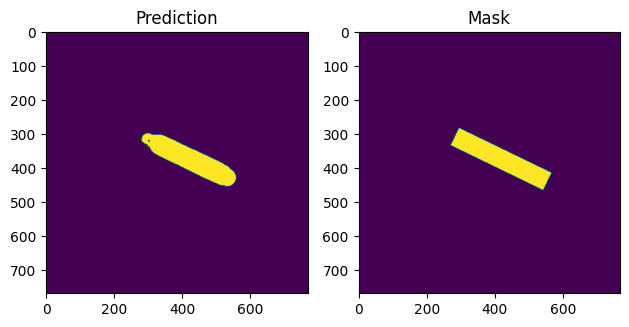

In [42]:
Test_with_dice_score('train_ship_segmentations_v2.csv', 'test/', model=model, plot = True)

As one of the requirements of the challenge, the submission file has to be filled with model prediction results. What fill_submission_file function is for. predicted_to_coords can be considered like inversion of get_mask_coords function. The performing of this function turned out to be slow due to the large number of the test images (15 606) and possible incorrect behavior of the model because of poor model training. For demonstration, this function is applied for the top 20 values in  'sample_submission_v2.csv'.

In [47]:
#Function for testing the test image set provided in the .zip file of the challange (test_v2)
#and filling the submission form with the results
#the 'top' parameter takes top n images in the submission form for testing
def fill_submission_file(target_file, source_file, test_path, model, top):
    #Transforms model prediction data into mask points for submission file format
    def predicted_to_coords(pred_):
        crds_str = ""
        i = j = 0
        while(i < np.shape(pred_)[0]):
            j = 0
            while(j < (np.shape(pred_)[1] - 1)):
                if pred_[i][j] == True:
                    if crds_str != "":
                        start_point = ' '
                    else:
                        start_point = ""
                    start_point += str((i + 1)*np.shape(pred_)[0] + (j + 1))
                    k = 0
                    while((pred_[i][j] == True) & (j < (np.shape(pred_)[1] - 1))):
                        k +=1
                        j +=1
                    crds_str += start_point + ' ' + str(k)
                else:
                    j += 1
            i += 1

        return crds_str
    
    submission_data_frame = pd.read_csv(source_file)
    for row in tqdm(range(top)):   
        img_path = test_path + submission_data_frame.iloc[row]['ImageId']
        img = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        img[0] = imread(img_path)[:,:,:IMG_CHANNELS]
        pred = model.predict(img, verbose=0)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        pred = pred.astype(np.bool_)
        submission_data_frame.iloc[row]['EncodedPixels'] = predicted_to_coords(pred[0])
    submission_data_frame.to_csv(target_file, index=False)

Note If 'test_v2' folder is absent fill_submission_file function won't work!

In [44]:
fill_submission_file('submission.csv', 'sample_submission_v2.csv', 'test_v2/', model, 20)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.30s/it]


In [45]:
subm_file = pd.read_csv('train_ship_segmentations_v2.csv')
subm_file.head(20)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
